In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Set path to data files
apps_df = pd.read_csv('../data/googleplaystore.csv')
reviews_df = pd.read_csv('../data/googleplaystore_user_reviews.csv')

# Preview the data
apps_df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [12]:
# Drop rows with missing values
apps_df.dropna(inplace=True)

# Remove duplicate apps
apps_df = apps_df.drop_duplicates(subset='App')

# Clean 'Installs' column
apps_df['Installs'] = apps_df['Installs'].fillna('0').astype(str).str.replace('[+,]', '', regex=True).astype(int)

# Clean 'Price' column
apps_df['Price'] = apps_df['Price'].fillna('$0').astype(str).str.replace(r'[^0-9.]', '', regex=True).astype(float)

# Convert 'Size' to numeric (approximate)
def size_to_mb(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024
    else:
        return np.nan

apps_df['Size_MB'] = apps_df['Size'].replace('Varies with device', np.nan)
apps_df['Size_MB'] = apps_df['Size_MB'].dropna().apply(size_to_mb)


In [14]:
# Drop nulls in 'Translated_Review'
reviews_df = reviews_df.dropna(subset=['Translated_Review'])

# Drop duplicates
reviews_df.drop_duplicates(inplace=True)

# Preview sentiment labels
reviews_df['Sentiment'].value_counts()


Sentiment
Positive    19015
Negative     6321
Neutral      4356
Name: count, dtype: int64

In [16]:
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment scoring
reviews_df['Sentiment_Score'] = reviews_df['Translated_Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Create new sentiment label
def categorize(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

reviews_df['Predicted_Sentiment'] = reviews_df['Sentiment_Score'].apply(categorize)

# Compare with original sentiment
reviews_df[['Sentiment', 'Predicted_Sentiment']].head()


,Sentiment,Predicted_Sentiment
0,Positive,Positive
1,Positive,Positive
3,Positive,Positive
4,Positive,Positive
5,Positive,Positive


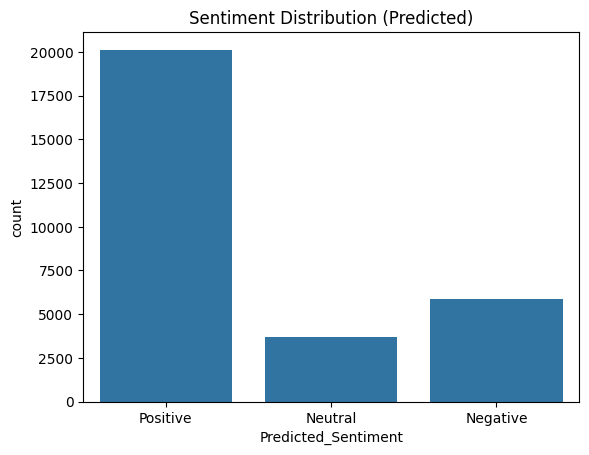

In [18]:
# Sentiment distribution
sns.countplot(data=reviews_df, x='Predicted_Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution (Predicted)')
plt.show()


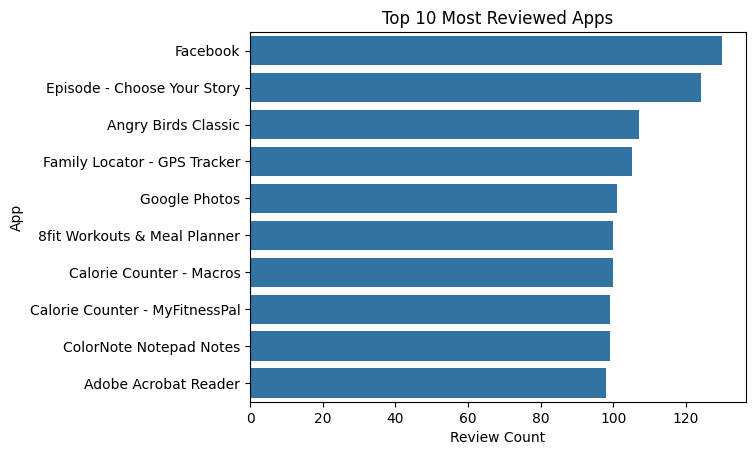

In [20]:
# Most reviewed apps
top_apps = reviews_df['App'].value_counts().head(10)
sns.barplot(x=top_apps.values, y=top_apps.index)
plt.title('Top 10 Most Reviewed Apps')
plt.xlabel('Review Count')
plt.show()


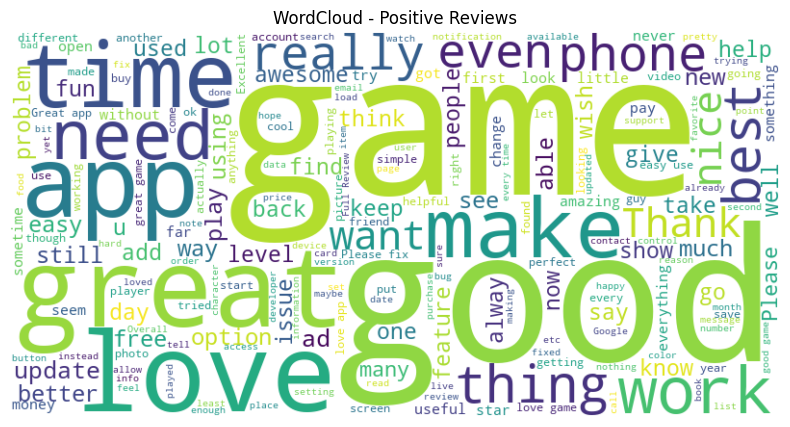

In [22]:
# WordCloud for Positive Reviews
positive_reviews = ' '.join(reviews_df[reviews_df['Predicted_Sentiment']=='Positive']['Translated_Review'])
wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Reviews')
plt.show()


In [24]:
# Grouped sentiment for each app
sentiment_summary = reviews_df.groupby(['App', 'Predicted_Sentiment']).size().unstack().fillna(0)

# Merge with app data
final_df = apps_df.merge(sentiment_summary, on='App', how='left')

# Save to Excel for Tableau
final_df.to_excel('../data/playstore_sentiment_tableau.xlsx', index=False)
print("Cleaned data exported for Tableau.")


Cleaned data exported for Tableau.


## Sentiment Analysis using TextBlob

This step applies Natural Language Processing to user reviews using TextBlob. For each review, we calculate:
- **Polarity**: A value from -1 (negative) to +1 (positive)
- **Subjectivity**: A value from 0 (objective) to 1 (subjective)

Based on polarity, reviews are labeled as:
- **Positive**: polarity > 0.1
- **Neutral**: polarity between -0.1 and 0.1
- **Negative**: polarity < -0.1


In [26]:
# Install TextBlob (if needed)
!pip install textblob

# Only once: download corpora
from textblob import download_corpora
download_corpora.download_all()



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\sidda\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading 

In [28]:
from textblob import TextBlob

# Drop rows with missing reviews
reviews_df = reviews_df.dropna(subset=['Translated_Review'])

# Apply sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

reviews_df[['Polarity', 'Subjectivity']] = reviews_df['Translated_Review'].apply(get_sentiment)

# Label sentiment
def label_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

reviews_df['Sentiment'] = reviews_df['Polarity'].apply(label_sentiment)

# Preview output
reviews_df[['Translated_Review', 'Polarity', 'Subjectivity', 'Sentiment']].head()


,Translated_Review,Polarity,Subjectivity,Sentiment
0,I like eat delicious food. That's I'm cooking ...,1.00,0.533333,Positive
1,This help eating healthy exercise regular basis,0.25,0.288462,Positive
3,Works great especially going grocery store,0.40,0.875000,Positive
4,Best idea us,1.00,0.300000,Positive
5,Best way,1.00,0.300000,Positive
